# Graph Neural Network for gene expression single-sample networks

This notebook is used to train a GNN with our constructed single-sample networks from gene expression data.

In [1]:
# Libraries
import os
import pandas as pd
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.data.data import Data as Data2
from torch_geometric.data.data import DataEdgeAttr
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GraphConv, GATConv, global_mean_pool, global_max_pool
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import umap

project_id = "PRJNA248469"

gene_data = pd.read_csv(f"data/IBD_Andre_data_filtered/{project_id}_matrix_filtered.tsv", sep = "\t")
# Get gene count data into format
gene_data_t = gene_data.rename(columns={"gene_symbol":"samples"}).set_index("samples").T
# Normalize data (log2 CPM)
lib_size = gene_data_t.sum(axis=1)
if (lib_size == 0).any():
    raise ValueError("One or more samples have zero library size (not possible)")
cpm = gene_data_t.div(lib_size, axis=0) * 1e6
norm_data = np.log2(cpm + 1.0)

metadata = pd.read_csv(f"data/IBD_Andre_data_filtered/{project_id}_metadata.txt", sep = ",")
ppi_network = pd.read_csv(f"data/IBD_Andre_data_filtered/{project_id}_ppi_network.tsv", sep = "\t")

# Filter data that is from undesired phenotype group
rel_metadata = metadata[["BioSample", "source_name"]].rename(columns={"BioSample":"sample", "source_name":"phenotype"})
joint_data = rel_metadata.merge(norm_data, left_on="sample", right_index=True, how="inner")

# for project PRJNA565216
# joint_data = joint_data[joint_data["phenotype"].isin(["Control_Ileum", "Ulcerative Colitis_Ileum", "Crohn's Disease_Ileum"])].reset_index(drop=True)

# for project PRJNA248469
joint_data = joint_data[joint_data["phenotype"].str.contains("IBD|CD|UC")].reset_index(drop=True)
joint_data["phenotype"] = joint_data["phenotype"].str.split(",").str[-1].str.strip()
joint_data = joint_data.set_index("sample")

torch.serialization.add_safe_globals([Data2, DataEdgeAttr])

pyg_data_pearson = torch.load(f"graph_data/{project_id}/pearson/pyg_data.pt", weights_only=False)
pyg_data_spearman = torch.load(f"graph_data/{project_id}/spearman/pyg_data.pt", weights_only=False)

print(type(pyg_data_pearson), len(pyg_data_pearson))
print(type(pyg_data_spearman), len(pyg_data_spearman))

/home/s243564/miniforge3/envs/gea/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<class 'list'> 303
<class 'list'> 303


## GNN model

We are going to define the GNN model to be used for training and generating graph-level embeddings. To begin with, we face our first problem: Graph convolution layers can't handle negative weights. To overcome this issue, we separate the edges into two: (1) positive weights indicating gene activation and (2) negative weights indicating inhibition. Both of them are passed independently to two different GNN modules and are combined at the end to get the final embeddings.

### Splitting edges

In [2]:
def split_edges(data_list: list) -> list:
    processed_list = []
    for data in data_list:
        # Create deep copy
        new_data = data.clone()

        # Ensuring dimensionality of indices
        if new_data.edge_attr.dim() > 1:
            edge_attr_squeezed = new_data.edge_attr.squeeze()
        else:
            edge_attr_squeezed = new_data.edge_attr

        # 1. mask for positive and negative edges
        pos_mask = edge_attr_squeezed > 0 
        neg_mask = edge_attr_squeezed < 0

        # 2. create attributes for positive edges
        new_data.pos_edge_index = new_data.edge_index[:, pos_mask]
        new_data.pos_edge_attr = new_data.edge_attr[pos_mask]

        # 3. create attributes for negative edges
        new_data.neg_edge_index = new_data.edge_index[:, neg_mask]
        new_data.neg_edge_attr = torch.abs(new_data.edge_attr[neg_mask])

        # 4. clean up original attributes to avoid confusion
        del new_data.edge_index
        del new_data.edge_attr

        processed_list.append(new_data)
    
    return processed_list

### Adding class labels to graphs

The graph we use are conditioned by the phenotype associated to them. We are going to add this information to train the model in a supervised manner.

In [3]:
data_list = split_edges(pyg_data_pearson)

# Building a map for label -> int
bio_to_source = joint_data["phenotype"].to_dict()
label_names = sorted(joint_data["phenotype"].unique())
label_map = {lab: i for i, lab in enumerate(label_names)}
n_classes = len(label_names)

# Attaching int labels to each Data object
for d in data_list:
    if hasattr(d, "sample_name"):
        s = d.sample_name
        if isinstance(s, (list, tuple)):
            s = s[0]
    
    else:
        raise RuntimeError("Each data object must have a 'sample_name' attribute mapping to metadata['BioSample'].")
    
    if s not in bio_to_source:
        raise RuntimeError(f"Sample name {s} not found in metadata['BioSample']. Check consistency.")
    
    src = bio_to_source[s]
    d.y = torch.tensor(label_map[src], dtype=torch.long)

### GNN class definition

Now we can define our GNN model that will handle both edge types (signed).

In [4]:
class GNN_Signed(nn.Module):
    def __init__(self,
                 in_channels: int,
                 n_classes: int,
                 hidden_channels: int = 128,
                 latent_dim: int = 64,
                 num_layers: int = 3,
                 conv_type: str = "gcn",
                 dropout: float = 0.2,
                 ):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.hidden_channels = hidden_channels
        self.latent_dim = latent_dim
        self.num_layers = num_layers
        self.dropout = dropout

        Conv = {"gcn":GCNConv, "graph":GraphConv, "gat":GATConv}.get(conv_type, GCNConv)

        self.pos_convs = nn.ModuleList()
        self.neg_convs = nn.ModuleList()

        for i in range(num_layers):
            first_layer = (i == 0)
            last_layer = (i == num_layers - 1)
            in_c = in_channels if first_layer else hidden_channels
            out_c = latent_dim if last_layer else hidden_channels
            self.pos_convs.append(Conv(in_c, out_c))
            self.neg_convs.append(Conv(in_c, out_c))
        
        # MLP on top of node latent - receives the concatenated embeddings
        self.node_mlp = nn.Sequential(
            nn.Linear(latent_dim * 2, latent_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # decoder: reconstruct node featuers from node latent
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, latent_dim // 2),
            nn.ReLU(),
            nn.Linear(latent_dim // 2, in_channels)
        )

        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, latent_dim // 2),
            nn.ReLU(),
            nn.Linear(latent_dim // 2, n_classes)
        )
    
    def encode(self, x, pos_edge_index, neg_edge_index, pos_edge_attr, neg_edge_attr):
        # Apply convolution layers with activation
        # Positive stream
        h_pos = x
        for i, conv in enumerate(self.pos_convs):
            h_pos = conv(h_pos, pos_edge_index, pos_edge_attr)
            if i != len(self.pos_convs) - 1:
                h_pos = F.relu(h_pos)
                h_pos = F.dropout(h_pos, p=self.dropout, training = self.training)

        # Negative stream
        h_neg = x
        for i, conv in enumerate(self.neg_convs):
            h_neg = conv(h_neg, neg_edge_index, neg_edge_attr)
            if i != len(self.neg_convs) - 1:
                h_neg = F.relu(h_neg)
                h_neg = F.dropout(h_neg, p=self.dropout, training = self.training)

        # concatenate streams
        h = torch.cat([h_pos, h_neg], dim=-1)

        # final node embedding 
        z_node = self.node_mlp(h)
        return z_node
    
    def decode(self, z_node):
        x_hat = self.decoder(z_node)
        return x_hat

    def classify(self, z_graph):
        x_class = self.classifier(z_graph)
        return x_class
    
    def forward(self, data):
        x = data.x

        # get attributes
        pos_edge_index, pos_edge_attr = data.pos_edge_index, data.pos_edge_attr
        neg_edge_index, neg_edge_attr = data.neg_edge_index, data.neg_edge_attr

        # get node embeddings
        z_node = self.encode(x, pos_edge_index, neg_edge_index, pos_edge_attr, neg_edge_attr)
        # predict node atribute
        x_hat = self.decode(z_node)

        # graph-level embedding
        z_graph = global_mean_pool(z_node, data.batch)
        # predict graph class
        z_logits = self.classify(z_graph)

        return x_hat, z_node, z_graph, z_logits
    
    def train_loop(self, train_loader, device,
                   epochs = 50, alpha = 1.0, lr=1e-3, weight_decay = 1e-5,
                   grad_clip = 5.0, ckpt_path=None, log_every=5):
        self.to(device)
        opt = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(opt, step_size=int(epochs*0.2), gamma=0.1)
        losses = []

        total_steps = len(train_loader) * epochs
        progress_bar = tqdm(
            range(total_steps),
            desc="Training GNN model."
        )
        avg_loss = 0

        for epoch in range(1, epochs+1):
            self.train()
            epoch_loss = 0.0
            n_batches = 0
            for batch in train_loader:
                batch = batch.to(device)
                opt.zero_grad()
                x_hat, z_node, z_graph, z_logits = self.forward(batch)

                if x_hat.shape != batch.x.shape:
                    raise RuntimeError(f"Reconstructed x shape {x_hat.shape} != original {batch.x.shape}")
                
                recon_loss = F.mse_loss(x_hat, batch.x)
                cls_loss = F.cross_entropy(z_logits, batch.y)
                loss = recon_loss + alpha * cls_loss
                loss.backward()
                
                if grad_clip is not None:
                    torch.nn.utils.clip_grad_norm_(self.parameters(), grad_clip)
                opt.step()
                epoch_loss += float(loss.detach().cpu().item())
                n_batches += 1

                progress_bar.set_postfix(
                    epoch=f"{epoch}/{epochs}",
                    avg_loss=f"{avg_loss:.6f}",
                    feature_loss=f"{recon_loss:.6f}",
                    class_loss=f"{cls_loss:.6f}",
                    lr = f"{scheduler.get_last_lr()[0]:.2e}"
                )
                progress_bar.update()

            scheduler.step()
            avg_loss = epoch_loss / max(1, n_batches)
            losses.append(avg_loss)
            
            if ckpt_path is not None and epoch % 50 == 0:
                torch.save(self.state_dict(), ckpt_path)
        
        if ckpt_path is not None:
            torch.save(self.state_dict(), ckpt_path)
        
        return losses
    
    def get_graph_embeddings(self, loader, device):
        self.eval()
        embeddings = []
        sample_names = []
        with torch.no_grad():
            for batch in loader:
                batch = batch.to(device)

                _, _, z_graph, _ = self.forward(batch)
                embeddings.append(z_graph.cpu())

                if hasattr(batch, "sample_name"):
                    sample_names.extend(batch.sample_name)
        
        embeddings = torch.cat(embeddings, dim=0).numpy()
        return embeddings, (sample_names if len(sample_names)>0 else None)

## Training

In [5]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(42)

batch_size = 16
train_loader = DataLoader(data_list, batch_size=batch_size, shuffle=True)
embed_loader = DataLoader(data_list, batch_size=batch_size, shuffle=False) # this is used for extracting embeddings

in_channels = data_list[0].x.shape[1]

model = GNN_Signed(in_channels=in_channels,
                   n_classes=n_classes,
                   hidden_channels=128,
                   latent_dim=64,
                   num_layers=3,
                   conv_type="gcn",
                   dropout=0.2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
avg_losses = model.train_loop(train_loader, device, epochs = 200, alpha=10.0)

Training GNN model.: 100%|██████████| 3800/3800 [01:00<00:00, 63.04it/s, avg_loss=7.412189, class_loss=0.353103, epoch=200/200, feature_loss=4.066095, lr=1.00e-07]


## Embeddings

/home/s243564/miniforge3/envs/gea/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


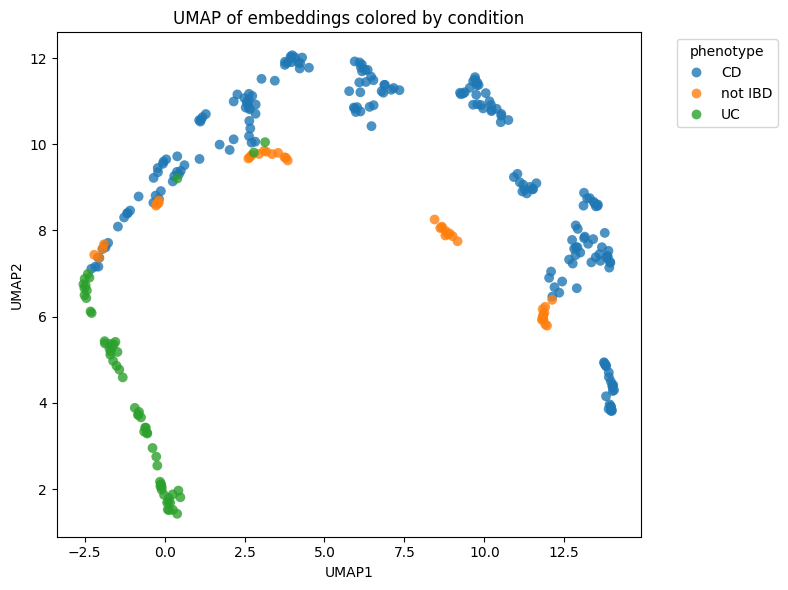

In [6]:
# Get embeddings
embeddings, sample_names = model.get_graph_embeddings(embed_loader, device)

# Create pd.DataFrame for embeddings
emb_df = pd.DataFrame()

if embeddings.shape[0] != len(sample_names):
    raise RuntimeError(f"Embeddings length {embeddings.shape[0]} doesn't match samples {len(sample_names)}.")

for i in range(len(sample_names)):
    emb = embeddings[i]
    s = sample_names[i]
    emb_df = pd.concat([emb_df, pd.DataFrame({"BioSample":s, "Embedding": [emb]})], axis=0).reset_index(drop=True)

# Add metadata
emb_df = emb_df.merge(joint_data["phenotype"].reset_index(drop=False).rename(columns={"sample":"BioSample"}), on="BioSample", how="inner")

# Stack embeddings
X = np.stack(emb_df["Embedding"].values)

# UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
umap_coords = reducer.fit_transform(X)

# Coordinates to df
emb_df[["UMAP1","UMAP2"]] = umap_coords

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(data=emb_df, x="UMAP1", y="UMAP2", hue="phenotype", s=50, alpha=0.8, edgecolor="none")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="phenotype")
plt.title("UMAP of embeddings colored by condition")
plt.tight_layout()
plt.show()

In [10]:
split_edges(pyg_data_pearson)

[Data(x=[1165, 1], sample_name='SAMN03322987', pos_edge_index=[2, 3501], pos_edge_attr=[3501, 1], neg_edge_index=[2, 4182], neg_edge_attr=[4182, 1]),
 Data(x=[1165, 1], sample_name='SAMN03323176', pos_edge_index=[2, 3634], pos_edge_attr=[3634, 1], neg_edge_index=[2, 4041], neg_edge_attr=[4041, 1]),
 Data(x=[1165, 1], sample_name='SAMN03323174', pos_edge_index=[2, 3516], pos_edge_attr=[3516, 1], neg_edge_index=[2, 4155], neg_edge_attr=[4155, 1]),
 Data(x=[1165, 1], sample_name='SAMN03323029', pos_edge_index=[2, 3565], pos_edge_attr=[3565, 1], neg_edge_index=[2, 4109], neg_edge_attr=[4109, 1]),
 Data(x=[1165, 1], sample_name='SAMN03323141', pos_edge_index=[2, 3632], pos_edge_attr=[3632, 1], neg_edge_index=[2, 4065], neg_edge_attr=[4065, 1]),
 Data(x=[1165, 1], sample_name='SAMN03323072', pos_edge_index=[2, 3539], pos_edge_attr=[3539, 1], neg_edge_index=[2, 4150], neg_edge_attr=[4150, 1]),
 Data(x=[1165, 1], sample_name='SAMN03323142', pos_edge_index=[2, 3569], pos_edge_attr=[3569, 1], ne

In [11]:
corr_method = "pearson"

emb_df.to_csv(f"graph_data/{project_id}/{corr_method}/embeddings.csv", index=False)